In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import nltk

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /home/vscode/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [49]:
import re
from pathlib import Path
from typing import Final, Sequence, TypeAlias

import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
from IPython.display import display
from matplotlib import pyplot as plt
from nltk.corpus import gutenberg
from numpy.typing import NDArray
from pandas import DataFrame

from authorship_tool.types_ import AuthorColl4dStr, Doc3dStr, Para2dStr, Tag
from authorship_tool.util import dim_reshaper
from authorship_tool.util.feature.dataset_generator import (
    ParagraphFeatureDatasetGenerator,
)
from authorship_tool.util.feature.pos import PosFeature
from authorship_tool.util.ml import cv_trainer, trainer
from authorship_tool.util.ml.model import (
    CrossValidationResult,
    CvGlobalExplanationData,
    LGBMSource,
    Score,
    ShapData,
    TrainingResult,
    dump,
    pred_crosstab,
)
from authorship_tool.util.path_util import GutenbergKFoldPaths, GutenbergPaths

In [50]:
np.seterr(divide="call")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [51]:
print(lgb.__version__)

4.4.0


In [52]:
for idx, file_id in enumerate(iterable=gutenberg.fileids()):
    print(f"#{idx+1}\t{file_id}")

#1	austen-emma.txt
#2	austen-persuasion.txt
#3	austen-sense.txt
#4	bible-kjv.txt
#5	blake-poems.txt
#6	bryant-stories.txt
#7	burgess-busterbrown.txt
#8	carroll-alice.txt
#9	chesterton-ball.txt
#10	chesterton-brown.txt
#11	chesterton-thursday.txt
#12	edgeworth-parents.txt
#13	melville-moby_dick.txt
#14	milton-paradise.txt
#15	shakespeare-caesar.txt
#16	shakespeare-hamlet.txt
#17	shakespeare-macbeth.txt
#18	whitman-leaves.txt


In [53]:
Author: TypeAlias = str
NumOfParas: TypeAlias = int

authors: set[Author] = {
    match.group(1)
    for file_id in gutenberg.fileids()
    if (match := re.search(r"^(.+?)-", file_id)) is not None
}

para_size_by_author: dict[Author, NumOfParas] = {}

for index, author in enumerate(authors):
    books_of_author: AuthorColl4dStr = [
        gutenberg.paras(fileids=file_id)
        for file_id in gutenberg.fileids()
        if author in file_id
    ]

    para_num: NumOfParas = len([para for paras in books_of_author for para in paras])
    para_size_by_author[author] = para_num

sorted_para_size_by_author: dict[Author, NumOfParas] = dict(
    sorted(para_size_by_author.items(), key=lambda item: item[1], reverse=True)
)

for idx, item in enumerate(sorted_para_size_by_author.items()):
    print(f"{idx + 1}:\t{item[0]} - {item[1]} paragraphs")

1:	bible - 24608 paragraphs
2:	austen - 5265 paragraphs
3:	chesterton - 4055 paragraphs
4:	edgeworth - 3726 paragraphs
5:	melville - 2793 paragraphs
6:	whitman - 2478 paragraphs
7:	shakespeare - 2372 paragraphs
8:	bryant - 1194 paragraphs
9:	carroll - 817 paragraphs
10:	blake - 284 paragraphs
11:	burgess - 266 paragraphs
12:	milton - 29 paragraphs


In [54]:
AUTHOR_A: Final[str] = "chesterton"
AUTHOR_B: Final[str] = "bryant"
PARAGRAPH_INIT_INDEX: Final[int] = 10
PARAGRAPH_END_INDEX: Final[int] = 1194

In [55]:
books_a: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_A in file_id
]

paras_a: Doc3dStr = [para for paras in books_a for para in paras][
    PARAGRAPH_INIT_INDEX:PARAGRAPH_END_INDEX
]

for para in paras_a[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_A}, {len(paras_a)} paragraphs\n")

" Well , the fact is ," said the other , " that much as I admire your rhetoric and the rhetoric of your school , from a purely verbal point of view , such little study of you and your school in human history as I have been enabled to make has led me to -- er -- rather singular conclusion , which I find great difficulty in expressing , especially in a foreign language ."
" Come , come ," said the Professor , encouragingly , " I ' ll help you out . How did my view strike you ?"
" Well , the truth is , I know I don ' t express it properly , but somehow it seemed to me that you always convey ideas of that kind with most eloquence , when -- er -- when ----"
" Oh ! get on ," cried Lucifer , boisterously .
" Well , in point of fact when your flying ship is just going to run into something . I thought you wouldn ' t mind my mentioning it , but it ' s running into something now ."
Lucifer exploded with an oath and leapt erect , leaning hard upon the handle that acted as a helm to the vessel . F

In [56]:
books_b: AuthorColl4dStr = [
    gutenberg.paras(fileids=file_id)
    for file_id in gutenberg.fileids()
    if AUTHOR_B in file_id
]

paras_b: Doc3dStr = [para for paras in books_b for para in paras][
    PARAGRAPH_INIT_INDEX:PARAGRAPH_END_INDEX
]

for para in paras_b[:20]:
    print(dim_reshaper.two_dim_to_str(para))

print(f"...\n\nAuthor: {AUTHOR_B}, {len(paras_b)} paragraphs\n")

" Who is there ?" she said .
The same soft little voice answered , " It ' s the Rain , and I want to come in !"
" No , you can ' t come in ," said the little Tulip .
Then it was very still for a long time . At last , there came a little rustling , whispering sound , all round the window : _rustle , whisper , whisper_ .
" Who is there ?" said the little Tulip .
" It ' s the Sunshine ," said a little , soft , cheery voice , " and I want to come in !"
" N -- no ," said the little Tulip , " you can ' t come in ." And she sat still again .
Pretty soon she heard the sweet little rustling noise at the keyhole .
" Who is there ?" she said .
" It ' s the Sunshine ," said the cheery little voice , " and I want to come in , I want to come in !"
" No , no ," said the little Tulip , " you cannot come in ."
By and by , as she sat so still , she heard _tap , tap , tap_ , and _rustle , whisper , rustle_ , up and down the window - pane , and on the door and at the keyhole .
" _Who is there ? _ " she sa

In [57]:
print(f"total: {len(paras_a + paras_b)} paragraphs (samples)")

total: 2368 paragraphs (samples)


In [58]:
all_paras: list[Para2dStr] = paras_a + paras_b

all_pos: list[Tag] = PosFeature(all_paras).tag_subcategories().all_pos

print(all_pos)

["''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'JJ_exp', 'JJ_lim', 'JJ_pp', 'JJ_presp', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB']


In [59]:
dataset_generator = ParagraphFeatureDatasetGenerator(tags=all_pos)

In [60]:
para_ans_pairs: Sequence[tuple[Para2dStr, bool]] = [
    (para, True) for para in paras_a
] + [(para, False) for para in paras_b]

In [61]:
dataset_list: list[pd.Series] = [
    dataset_generator.generate_from_paragraph(para, answer)
    for para, answer in para_ans_pairs
]

In [62]:
dataset: DataFrame = pd.concat(dataset_list, axis=1).reset_index(drop=True).T

In [63]:
dataset.columns = (*dataset_generator.columns, "answer")
for col, dtype in zip(
    dataset.columns,
    dataset_generator.dtypes + [bool],
    strict=True,
):
    dataset[col] = dataset[col].astype(dtype)

In [64]:
display(dataset.head(10))

,v1 sentences per paragraph,v2 words per paragraph,v3 close parenthesis present,v4 dash present,v5 semi-colon or colon present,v6 question mark present,v7 apostrophe present,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,v10 sentence with < 11 words,v11 sentence with > 34 words,v12 contains 'although',v13 contains 'however',v14 contains 'but',v15 contains 'because',v16 contains 'this',v17 contains 'others' or 'researchers',v18 contains numbers,v19 contains 2 times more capitals than period,v20 contains 'et',word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB,answer
0,1,77,False,True,False,False,False,0.000000,0.000000,False,True,False,False,False,False,False,False,False,True,False,0.701299,3.844156,0.207792,0.597403,0.207792,0.0,0.000000,0.0,0.0,0.077922,0.000000,0.025974,0.025974,0.000000,0.064935,0.000000,0.0,0.116883,0.116883,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.000000,0.168831,0.000000,0.0,0.000000,0.0,0.000000,0.064935,0.038961,0.077922,0.0,0.0,0.000000,0.0,0.025974,0.000000,0.038961,0.012987,0.012987,0.051948,0.038961,0.025974,0.012987,0.000000,0.0,0.000000,True
1,2,26,False,False,False,True,True,6.000000,12.000000,True,False,False,False,False,False,False,False,False,True,False,0.846154,3.153846,0.423077,0.730769,0.423077,0.0,0.038462,0.0,0.0,0.115385,0.038462,0.000000,0.000000,0.000000,0.038462,0.000000,0.0,0.000000,0.038462,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.000000,0.153846,0.115385,0.0,0.000000,0.0,0.000000,0.153846,0.038462,0.038462,0.0,0.0,0.038462,0.0,0.000000,0.000000,0.038462,0.076923,0.000000,0.000000,0.038462,0.000000,0.000000,0.000000,0.0,0.038462,True
2,1,41,False,True,False,False,True,0.000000,0.000000,False,True,False,False,True,False,False,False,False,True,False,0.804878,3.390244,0.365854,0.585366,0.365854,0.0,0.024390,0.0,0.0,0.097561,0.000000,0.048780,0.024390,0.000000,0.048780,0.000000,0.0,0.073171,0.000000,0.0,0.02439,0.0,0.000000,0.00000,0.0,0.000000,0.146341,0.000000,0.0,0.024390,0.0,0.000000,0.146341,0.000000,0.097561,0.0,0.0,0.000000,0.0,0.024390,0.000000,0.000000,0.024390,0.000000,0.000000,0.121951,0.024390,0.000000,0.000000,0.0,0.048780,True
3,2,11,False,False,False,False,False,2.500000,5.000000,True,False,False,False,False,False,False,False,False,False,False,1.000000,3.363636,0.545455,0.909091,0.545455,0.0,0.000000,0.0,0.0,0.090909,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.090909,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0.181818,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.090909,0.0,0.0,0.000000,0.0,0.000000,0.090909,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,True
4,2,39,False,False,False,False,True,0.500000,1.000000,False,False,False,False,True,False,False,False,False,False,False,0.871795,3.512821,0.205128,0.538462,0.205128,0.0,0.051282,0.0,0.0,0.051282,0.025641,0.000000,0.025641,0.000000,0.000000,0.000000,0.0,0.128205,0.025641,0.0,0.00000,0.0,0.000000,0.00000,0.0,0.000000,0.153846,0.025641,0.0,0.000000,0.0,0.000000,0.102564,0.051282,0.076923,0.0,0.0,0.000000,0.0,0.025641,0.000000,0.025641,0.025641,0.102564,0.000000,0.051282,0.025641,0.000000,0.000000,0.0,0.025641,True
5,4,93,False,False,False,False,True,9.756408,17.333333,False,True,False,False,False,False,False,False,False,False,False,0.741935,3.763441,0.118280,0.612903,0.118280,0.0,0.000000,0.0,0.0,0.053763,0.043011,0.000000,0.032258,0.000000,0.118280,0.000000,0.0,0.139785,0.075269,0.0,0.00000,0.0,0.010753,0.00000,0.0,0.010753,0.172043,0.021505,0.0,0.053763,0.0,0.021505,0.021505,0.000000,0.032258,0.0,0.0,0.000000,0.0,0.032258,0.000000,0.021505,0.053763,0.032258,0.032258,0.000000,0.000000,0.010753,0.010753,0.0,0.000000,True
6,5,81,False,True,Fa

In [65]:
print(dataset.shape)

(2368, 72)


In [66]:
print(dataset.dtypes)

v1 sentences per paragraph                          int64
v2 words per paragraph                              int64
v3 close parenthesis present                         bool
v4 dash present                                      bool
v5 semi-colon or colon present                       bool
v6 question mark present                             bool
v7 apostrophe present                                bool
v8 standard deviation of sentence length          float64
v9 length difference for consecutive sentences    float64
v10 sentence with < 11 words                         bool
v11 sentence with > 34 words                         bool
v12 contains 'although'                              bool
v13 contains 'however'                               bool
v14 contains 'but'                                   bool
v15 contains 'because'                               bool
v16 contains 'this'                                  bool
v17 contains 'others' or 'researchers'               bool
v18 contains n

In [67]:
print(dataset.isna().sum())

v1 sentences per paragraph                        0
v2 words per paragraph                            0
v3 close parenthesis present                      0
v4 dash present                                   0
v5 semi-colon or colon present                    0
v6 question mark present                          0
v7 apostrophe present                             0
v8 standard deviation of sentence length          0
v9 length difference for consecutive sentences    0
v10 sentence with < 11 words                      0
v11 sentence with > 34 words                      0
v12 contains 'although'                           0
v13 contains 'however'                            0
v14 contains 'but'                                0
v15 contains 'because'                            0
v16 contains 'this'                               0
v17 contains 'others' or 'researchers'            0
v18 contains numbers                              0
v19 contains 2 times more capitals than period    0
v20 contains

In [68]:
display(dataset.describe())

,v1 sentences per paragraph,v2 words per paragraph,v8 standard deviation of sentence length,v9 length difference for consecutive sentences,word variation,average word length,non alphabetic characters frequency,uncommon word frequency,non-alphabetic characters frequency,numeric value frequency,'',(,),",",.,:,CC,CD,DT,EX,FW,IN,JJ,JJR,JJS,JJ_exp,JJ_lim,JJ_pp,JJ_presp,MD,NN,NNP,NNPS,NNS,PDT,POS,PRP,PRP$,RB,RBR,RBS,RP,SYM,TO,UH,VB,VBD,VBG,VBN,VBP,VBZ,WDT,WP,WP$,WRB
count,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.0,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000,2368.000000
mean,2.750422,54.692990,4.613291,7.049314,0.815300,3.553922,0.236206,0.650300,0.236206,0.0,0.006030,0.000220,0.000085,0.051623,0.043972,0.014009,0.034868,0.004124,0.090702,0.002154,0.000342,0.082993,0.062919,0.001687,0.001023,0.000292,0.001276,0.000349,0.000082,0.010585,0.137234,0.081216,0.000292,0.023916,0.001304,0.003188,0.072579,0.017889,0.049712,0.001119,0.000284,0.005829,0.000198,0.015489,0.001015,0.035090,0.069508,0.012066,0.012410,0.023303,0.011845,0.002444,0.006556,0.000098,0.006079
std,2.487612,60.006744,5.585927,9.078962,0.138651,0.542657,0.143200,0.119550,0.143200,0.0,0.018016,0.002261,0.001252,0.040569,0.037976,0.025295,0.032901,0.011024,0.052206,0.007900,0.003089,0.050781,0.054293,0.007487,0.005293,0.002579,0.006404,0.003607,0.002189,0.020466,0.068650,0.125314,0.002995,0.030466,0.005527,0.013118,0.052368,0.026566,0.045343,0.005210,0.002654,0.014708,0.003285,0.021540,0.007459,0.043229,0.044926,0.020590,0.020805,0.035719,0.023280,0.007758,0.019252,0.001245,0.017462
min,1.000000,1.000000,0.000000,0.000000,0.200000,1.000000,0.000000,0.384615,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,19.000000,0.000000,0.000000,0.714286,3.235907,0.129426,0.569231,0.129426,0.0,0.000000,0.000000,0.000000,0.023810,0.023256,0.000000,0.000000,0.000000,0.061728,0.000000,0.000000,0.050000,0.029412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.016667,0.000000,0.000000,0.000000,0.000000,0.035714,0.000000,0.010390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,34.000000,2.624669,4.000000,0.833333,3.560000,0.200000,0.622222,0.200000,0.0,0.000000,0.000000,0.000000,0.050000,0.038462,0.000000,0.034483,0.000000,0.090551,0.000000,0.000000,0.086957,0.058578,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.136364,0.045455,0.000000,0.014706,0.000000,0.000000,0.068966,0.000000,0.045045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025126,0.068966,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,69.000000,8.000000,11.308333,0.925926,3.875000,0.315789,0.700000,0.315789,0.0,0.000000,0.000000,0.000000,0.075320,0.056604,0.022222,0.054348,0.000000,0.119048,0.000000,0.000000,0.119048,0.087767,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014925,0.172414,0.093750,0.000000,0.038710,0.000000,0.000000,0.105263,0.030303,0.073590,0.000000,0.000000,0.000000,0.000000,0.027027,0.

In [69]:
df: DataFrame = dataset.iloc[:, :-1]
nd_category: NDArray = dataset.iloc[:, -1].to_numpy(dtype=np.bool_)

In [70]:
source: LGBMSource = LGBMSource(feature_data_frame=df, nd_category=nd_category)
result: TrainingResult = trainer.train_once(source)

[LightGBM] [Info] Number of positive: 942, number of negative: 952
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7725
[LightGBM] [Info] Number of data points in the train set: 1894, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497360 -> initscore=-0.010560
[LightGBM] [Info] Start training from score -0.010560


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [71]:
score: Score | None = result.score

In [72]:
if score is not None:
    print(f"auc-roc score: {score.auc_roc_score}")
    print(f"f1 score: {score.f1_score}")
    print(f"accuracy score: {score.accuracy_score}")

auc-roc score: 0.8601097178683386
f1 score: 0.7743271221532091
accuracy score: 0.770042194092827


In [73]:
display(pred_crosstab(result.splitted_dataset.test_ans, result.prediction.pred_ans))

predicted,False,True
actual,,
False,178,54
True,55,187


In [74]:
dump(result, GutenbergPaths)

In [75]:
FIRST_DATA_INDEX: Final[int] = 0
shap_data: ShapData = result.shap_data
explainer: shap.Explainer = shap_data.explainer

local_explanation = shap.Explanation(
    base_values=shap_data.base_values,
    values=shap_data.shap_values[FIRST_DATA_INDEX],
    data=shap_data.data.to_numpy()[FIRST_DATA_INDEX],
    feature_names=shap_data.data.columns,
)

global_explanation = shap.Explanation(
    base_values=shap_data.base_values,
    values=shap_data.shap_values,
    data=shap_data.data.to_numpy(),
    feature_names=shap_data.data.columns,
)

In [76]:
shap.initjs()

In [77]:
SHAP_GUTENBERG_FIGURE_DIR: Path = GutenbergPaths.shap_figure_dir

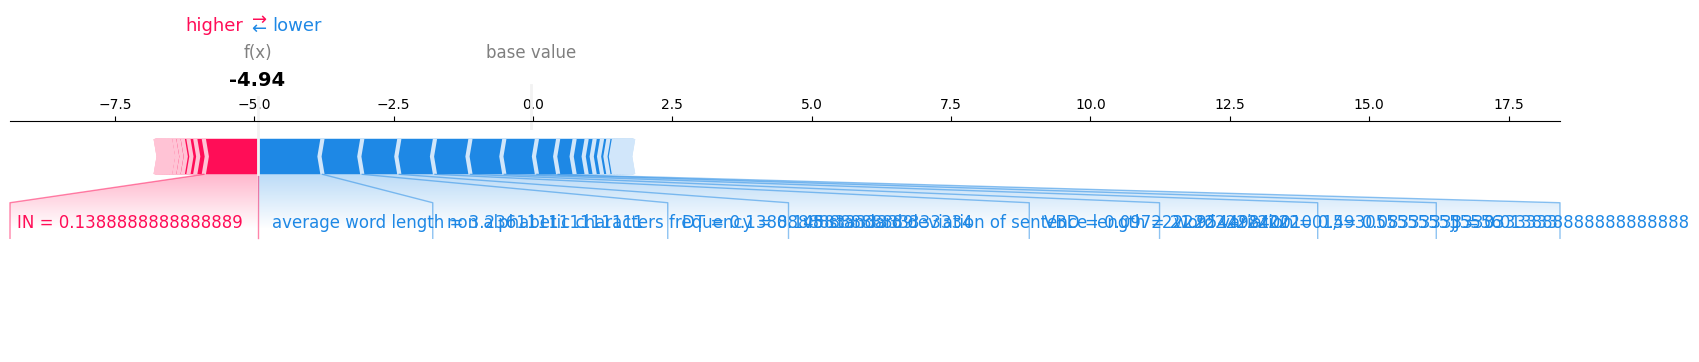

In [78]:
shap.plots.force(local_explanation)
shap.plots.force(
    local_explanation,
    matplotlib=True,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_force_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

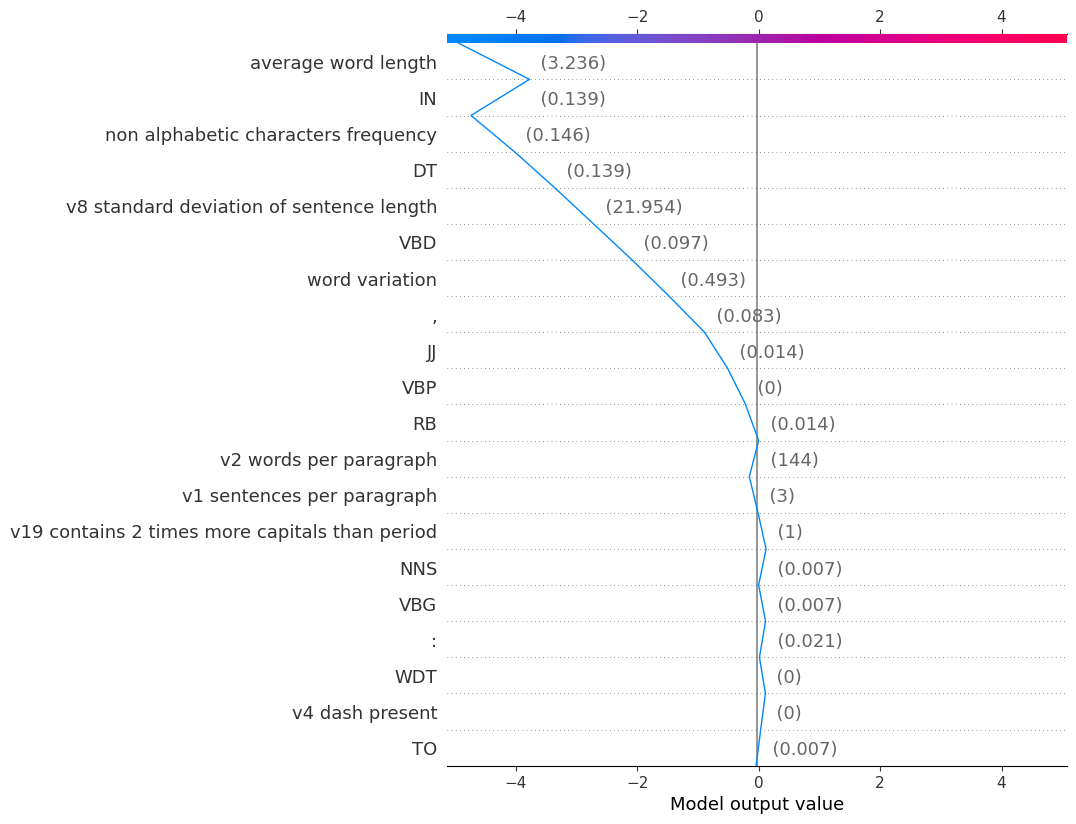

<Figure size 640x480 with 0 Axes>

In [79]:
shap.plots.decision(
    base_value=local_explanation.base_values,
    shap_values=local_explanation.values,
    features=local_explanation.data,
    feature_names=local_explanation.feature_names,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_decision_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

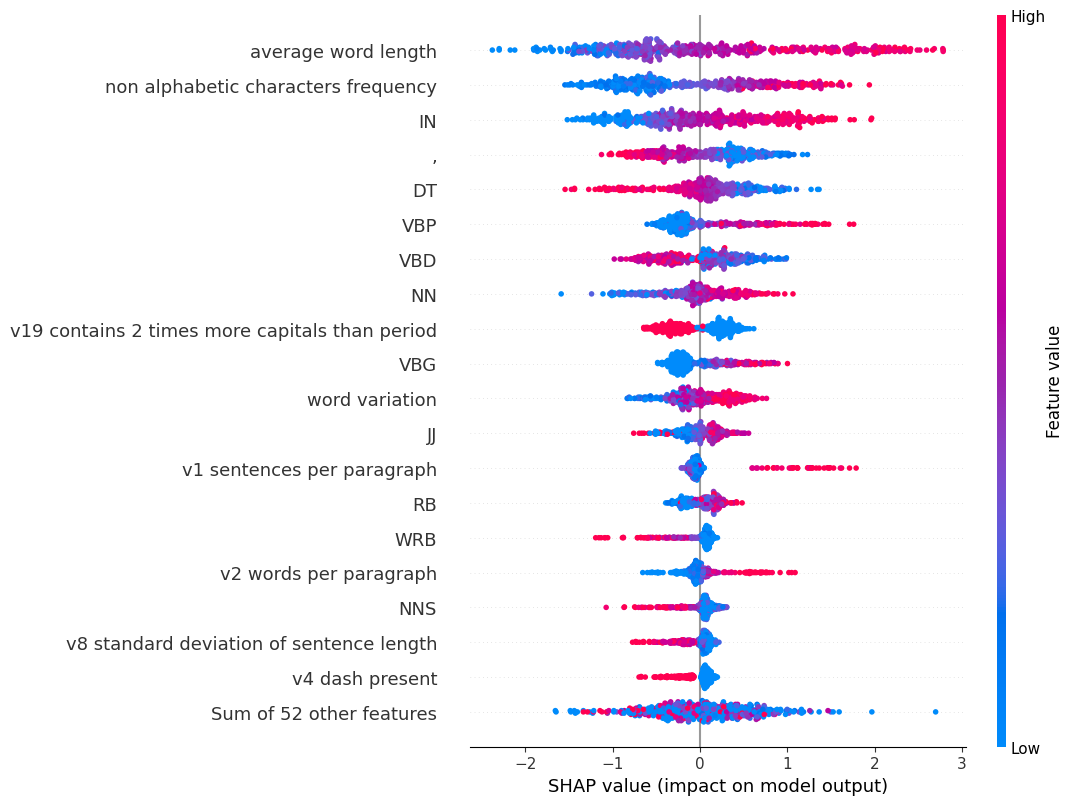

In [80]:
shap.plots.beeswarm(
    global_explanation,
    max_display=20,
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

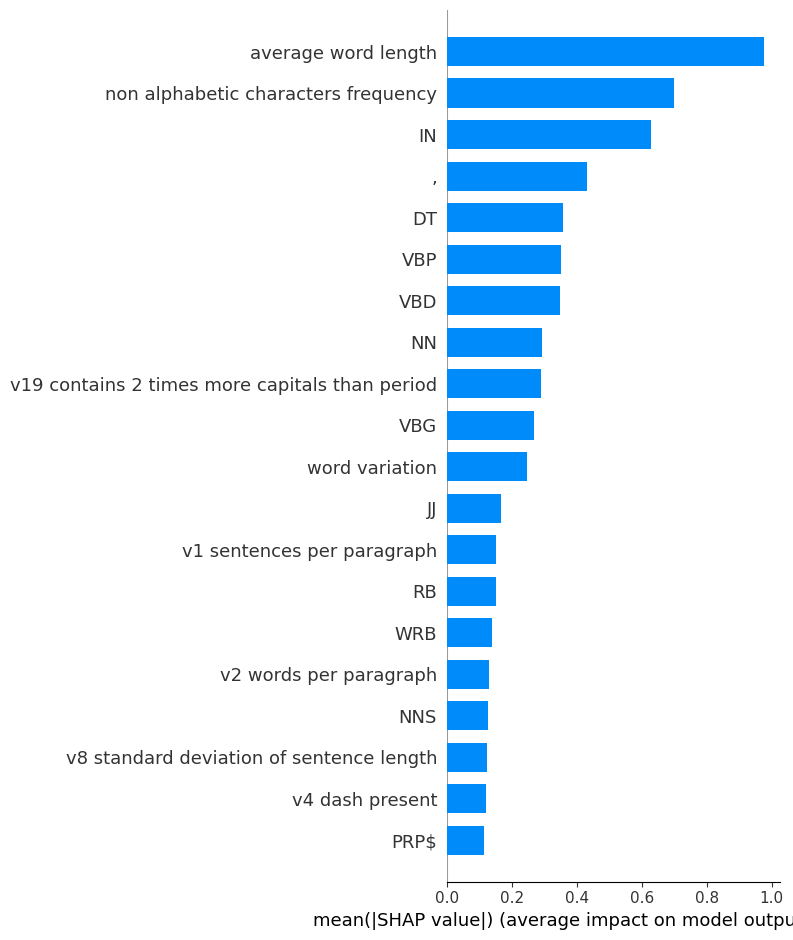

In [81]:
shap.summary_plot(
    global_explanation,
    plot_type="bar",
    show=False,
)
plt.savefig(
    SHAP_GUTENBERG_FIGURE_DIR.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

In [82]:
results_for_each_iters: list[TrainingResult] = cv_trainer.train_kfold(source, 100)

[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8291
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8284
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8293
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8287
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8275
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8295
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8282
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119
[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8280
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8287
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119
[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8275
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1167, number of negative: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8301
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497867 -> initscore=-0.008532
[LightGBM] [Info] Start training from score -0.008532
[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8281
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8286
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8270
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8272
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8286
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8294
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826
[LightGBM] [Info] Number of positive: 1167, number of negative: 1177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8295
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497867 -> initscore=-0.008532
[LightGBM] [Info] Start training from score -0.008532


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8293
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8298
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8268
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8305
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8295
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8288
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706
[LightGBM] [Info] Number of positive: 1172, number of negative: 1172


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8287
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8284
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8281
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8279
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413
[LightGBM] [Info] Number of positive: 1177, number of negative: 1167
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502133 -> initscore=0.008532
[LightGBM] [Info] Start training from score 0.008532


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706
[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8305
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706
[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8275
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000671 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8297
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8286
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8300
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826
[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8305
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8286
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8283
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8293
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8296
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1168, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8280
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498294 -> initscore=-0.006826
[LightGBM] [Info] Start training from score -0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001136 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8280
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8274
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8292
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8287
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498720 -> initscore=-0.005119
[LightGBM] [Info] Start training from score -0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8301
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8280
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8282
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500427 -> initscore=0.001706
[LightGBM] [Info] Start training from score 0.001706
[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8286
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8290
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501706 -> initscore=0.006826
[LightGBM] [Info] Start training from score 0.006826


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8295
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8305
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500853 -> initscore=0.003413
[LightGBM] [Info] Start training from score 0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8292
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1173
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8278
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499573 -> initscore=-0.001706
[LightGBM] [Info] Start training from score -0.001706


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8301
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8296
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501280 -> initscore=0.005119
[LightGBM] [Info] Start training from score 0.005119


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8282
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8286
[LightGBM] [Info] Number of data points in the train set: 2344, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499147 -> initscore=-0.003413
[LightGBM] [Info] Start training from score -0.003413


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1167, number of negative: 1178
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497655 -> initscore=-0.009382
[LightGBM] [Info] Start training from score -0.009382


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8296
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1171, number of negative: 1174


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8267
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1170, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8283
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498934 -> initscore=-0.004264
[LightGBM] [Info] Start training from score -0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8286
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001001 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8288
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8278
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8290
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8296
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1176, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501493 -> initscore=0.005970
[LightGBM] [Info] Start training from score 0.005970


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8293
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8289
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498507 -> initscore=-0.005970
[LightGBM] [Info] Start training from score -0.005970
[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8305
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1171, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8292
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559
[LightGBM] [Info] Number of positive: 1177, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8287
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501919 -> initscore=0.007676
[LightGBM] [Info] Start training from score 0.007676


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8294
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 64
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8303
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1169, number of negative: 1176
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001027 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8290
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498507 -> initscore=-0.005970
[LightGBM] [Info] Start training from score -0.005970


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8284
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1170, number of negative: 1175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8291
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498934 -> initscore=-0.004264
[LightGBM] [Info] Start training from score -0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8280
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8294
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1172, number of negative: 1173
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499787 -> initscore=-0.000853
[LightGBM] [Info] Start training from score -0.000853
[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8270
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1174, number of negative: 1171
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8300
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500640 -> initscore=0.002559
[LightGBM] [Info] Start training from score 0.002559
[LightGBM] [Info] Number of positive: 1175, number of negative: 1170
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8300
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501066 -> initscore=0.004264
[LightGBM] [Info] Start training from score 0.004264


/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


[LightGBM] [Info] Number of positive: 1173, number of negative: 1172
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8285
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500213 -> initscore=0.000853
[LightGBM] [Info] Start training from score 0.000853
[LightGBM] [Info] Number of positive: 1171, number of negative: 1174
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8292
[LightGBM] [Info] Number of data points in the train set: 2345, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499360 -> initscore=-0.002559
[LightGBM] [Info] Start training from score -0.002559
[LightGBM] [Info] Nu

/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
/workspaces/shap-authorship-analysis-demo/.venv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


In [83]:
cv_result: CrossValidationResult = cv_trainer.convert_results_to_cv_result(
    results_for_each_iters
)

In [84]:
cv_global_exp_data: CvGlobalExplanationData = (
    cv_trainer.convert_cv_result_to_global_exp_data(cv_result)
)

In [85]:
cv_score: Score = cv_trainer.calc_score_for_cv(cv_global_exp_data)

In [86]:
if cv_score is not None:
    print(f"auc-roc score:\t{cv_score.auc_roc_score}")
    print(f"f1 score:\t{cv_score.f1_score}")
    print(f"accuracy score:\t{cv_score.accuracy_score}")

auc-roc score:	0.8818730311815194
f1 score:	0.8010118043844857
accuracy score:	0.8006756756756757


In [87]:
display(pred_crosstab(cv_global_exp_data.test_ans, cv_global_exp_data.pred_ans))

predicted,False,True
actual,,
False,946,238
True,234,950


In [88]:
test_data = cv_global_exp_data.test_data
shap_vals = cv_global_exp_data.shap_vals

cv_global_explanation = shap.Explanation(
    values=shap_vals,
    data=test_data,
)

In [89]:
shap.initjs()

In [90]:
gutenberg_kfold_figure_dir_path = GutenbergKFoldPaths.shap_figure_dir

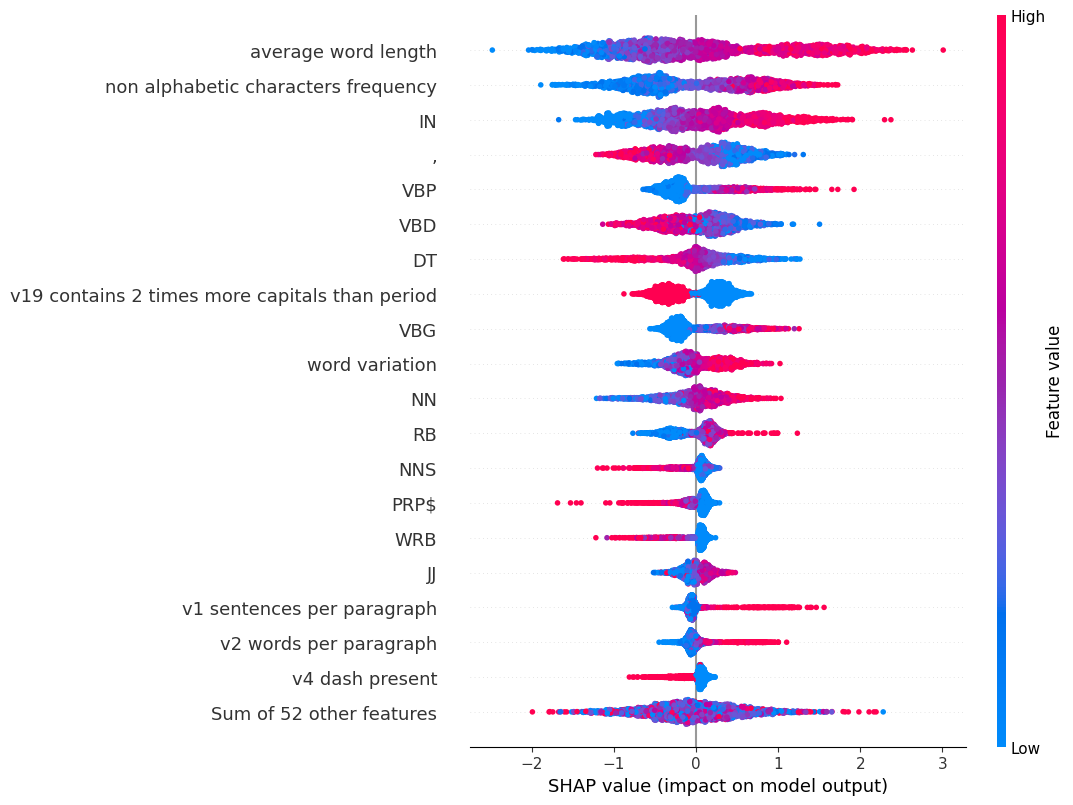

In [91]:
shap.plots.beeswarm(
    cv_global_explanation,
    max_display=20,
    show=False,
)

plt.savefig(
    gutenberg_kfold_figure_dir_path.joinpath("shap_summary_plot.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()

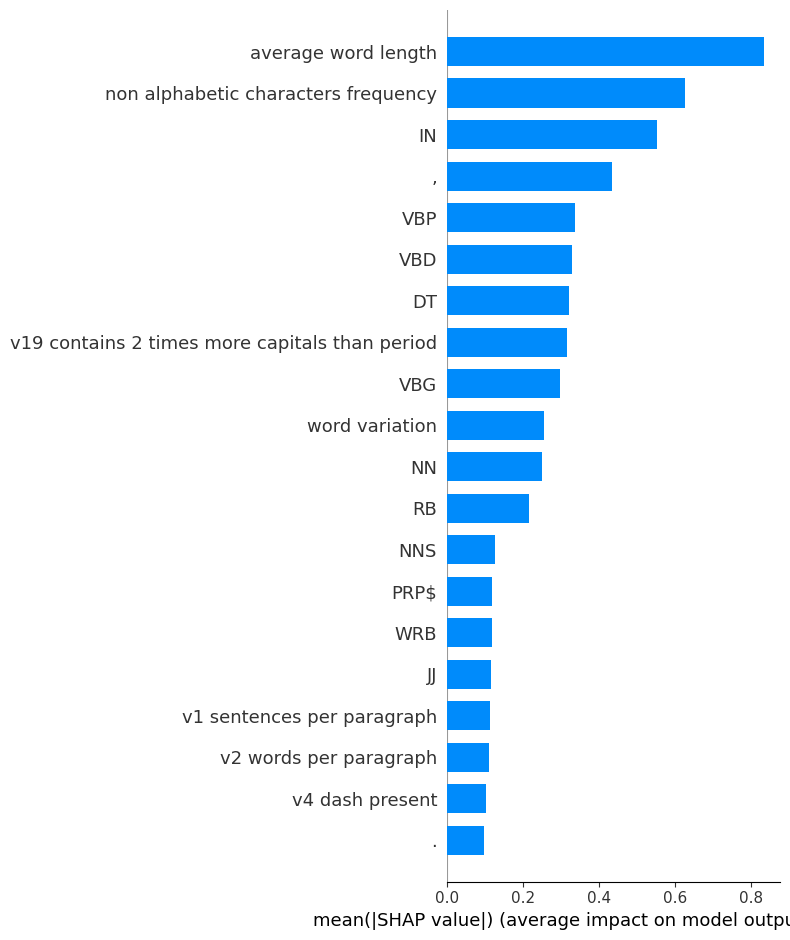

In [92]:
shap.summary_plot(
    cv_global_explanation,
    plot_type="bar",
    show=False,
)

plt.savefig(
    gutenberg_kfold_figure_dir_path.joinpath("shap_summary_plot_bar.svg"),
    bbox_inches="tight",
)
plt.show()
plt.clf()